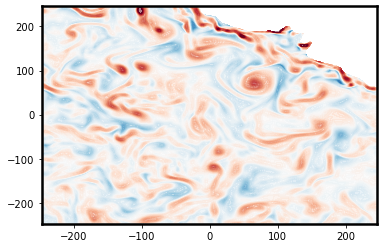

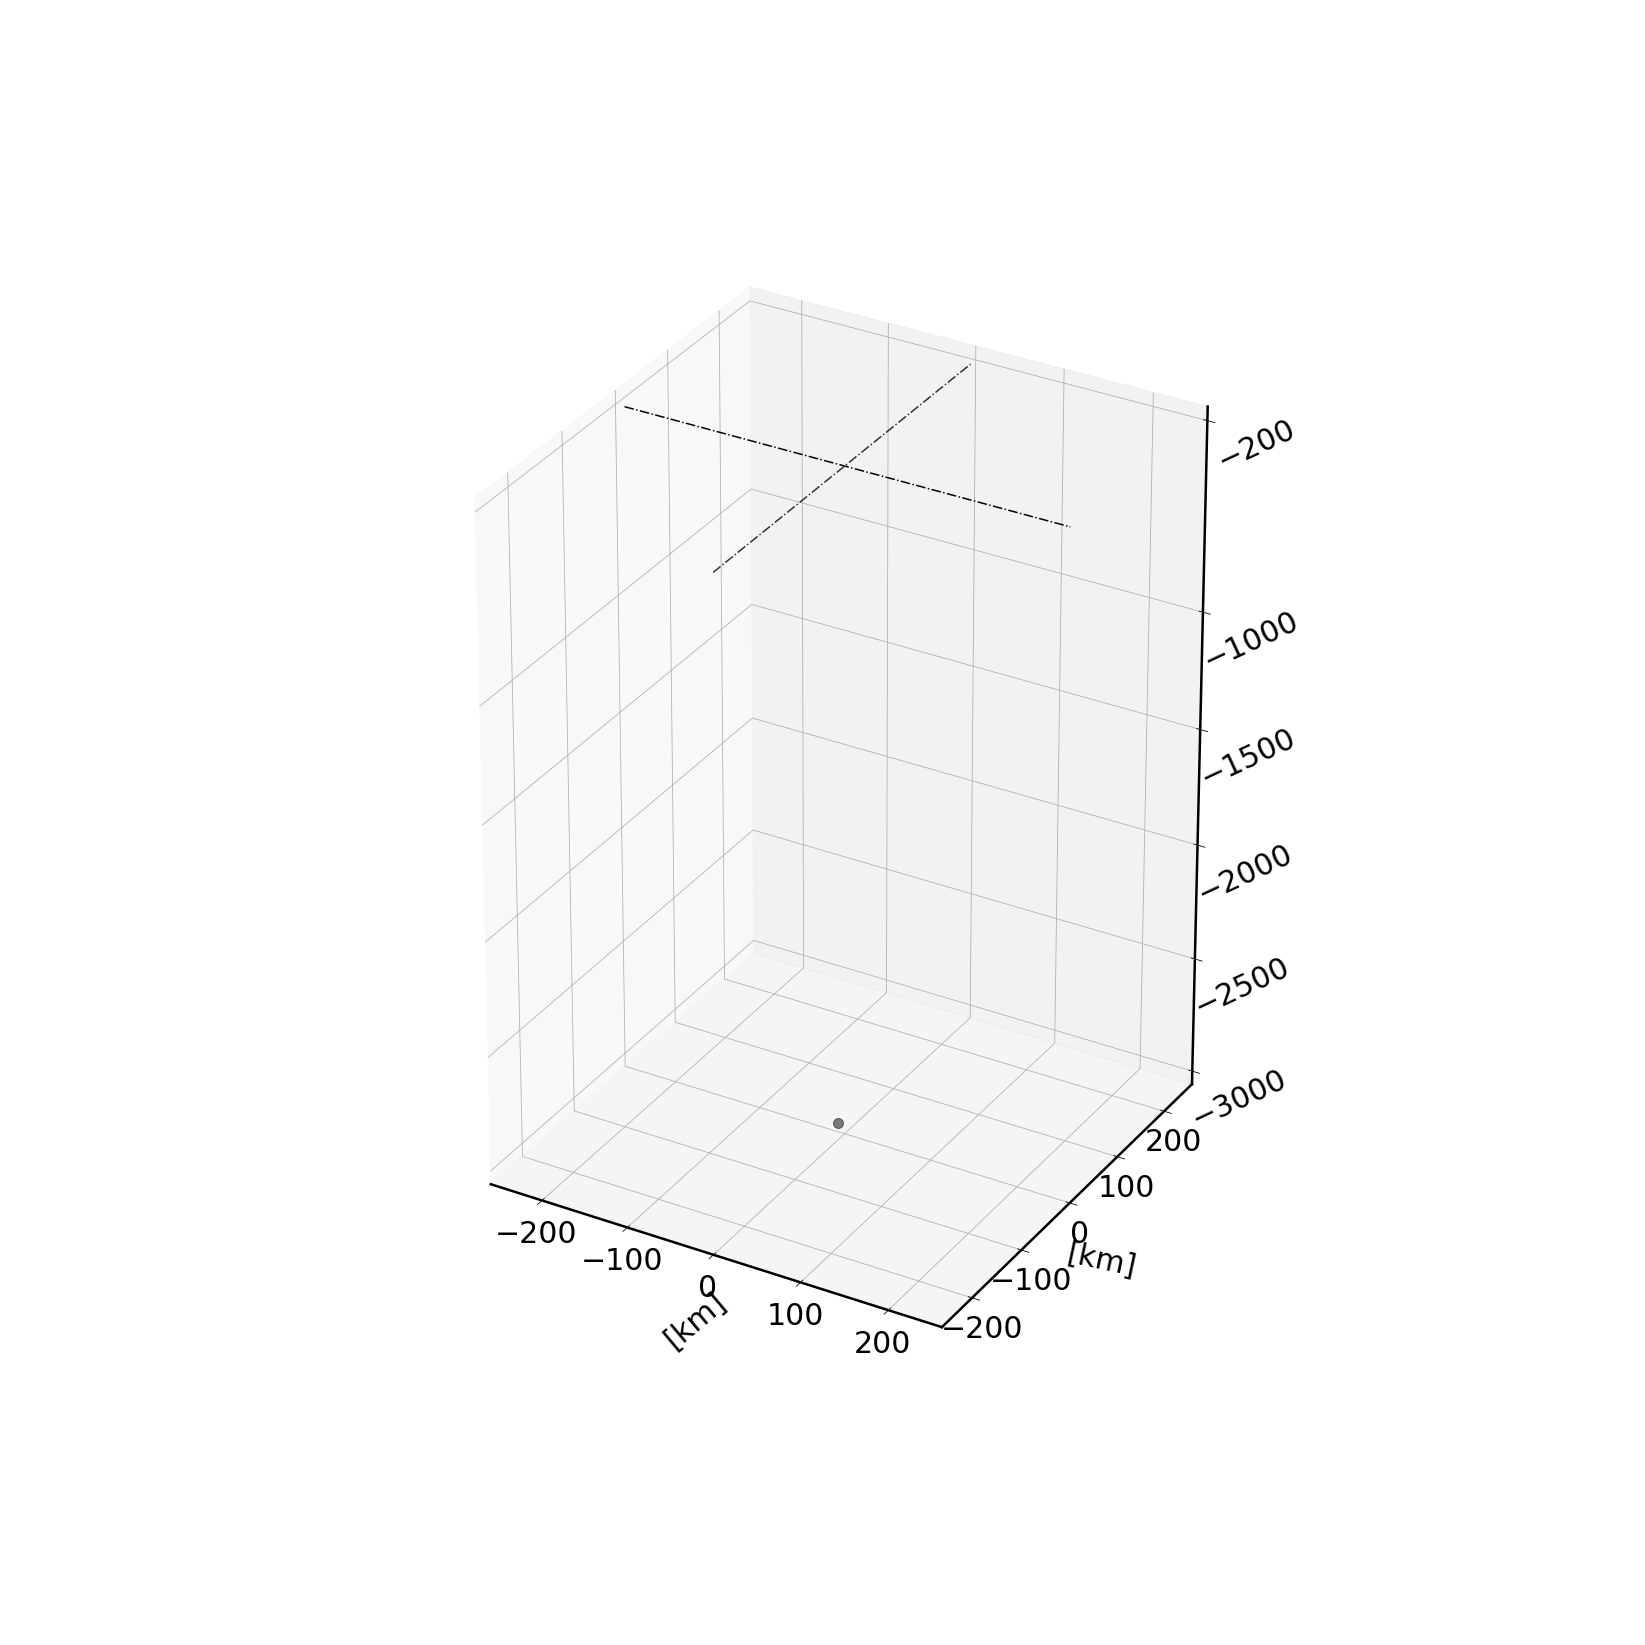

In [1]:
def plot_background_level_u_v_w(ic,jc,t,list_level):

    dx, dy = 1.979, 1.979 #grid size
    my_simul = 'apero'
    str_para = ' [{0},{1},{2},{3},[1,100,1]] '.format(jc-125,jc+125,ic-125,ic+125)
    parameters = my_simul +str_para+ format(t)
    simul = load(simul = parameters, floattype=np.float64,output=False)

    depths = -np.array(list_level)
    
    temp = var('temp',simul,depths=depths).data
    ssh = var('zeta',simul).data
    u = var('u',simul,depths=depths).data
    v = var('v',simul,depths=depths).data
    w = var('w',simul,depths=depths).data
    
    u = tools.u2rho(u)
    v = tools.v2rho(v)
    
    return (u,v,w)

from netCDF4 import Dataset
import numpy as np
import matplotlib.colors as colors
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import sys
sys.path.append("../")
from plot_function import *
from variables_create_data import *

labelsize = 30
labelpad = 40 
plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 2.50

import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
from IPython.display import clear_output
import matplotlib.cm as cm

from mpl_toolkits.mplot3d.axes3d import Axes3D
from mpl_toolkits.mplot3d import proj3d

"""                                                                                                                                                    
Scaling is done from here...                                                                                                                           
"""
x_scale=2
y_scale=2
z_scale=4

scale=np.diag([x_scale, y_scale, z_scale, 1.0])
scale=scale*(1.0/scale.max())
scale[3,3]=1.0

def short_proj():
    return np.dot(Axes3D.get_proj(ax), scale)

    
%matplotlib inline 

### LOADING PARTICLES DATA ###
#folder = '/home2/scratch/tpicard/Pyticles/outputs/'
folder = "/home/datawork-lemar-apero/tpicard/PYTICLE/"
tend = 1370
t0 = tend-120

file = folder + 'apero_trap3000m_wsed100_2000dx_100nx_00{0}_00{1}.nc'.format(t0,tend) #AC?
number_of_exp = 0

#List of the 36 sub-patches centers 
ic_all_list = np.linspace(1520.5,1610.5,6)
jc_all_list = np.linspace(569.5,659.5,6)
i_ic = 3
i_jc = 3

nc = Dataset(file, 'r')
part_x = nc.variables['px'][:,:]
part_y = nc.variables['py'][:,:]
pdepth = nc.variables['pdepth'][:,:] #(dt,nb_particle)

[ic,jc] = [ic_all_list[i_ic],  jc_all_list[i_jc]]

#[ic,jc] = np.load('/home2/datahome/tpicard/Pyticles/Inputs/ic_jc.npy')

index_part = spatial_filter(part_x,part_y,ic,jc,number_of_exp) #Filtre spatial #0, 20 ou 40

part_x = part_x[:,index_part]
part_y = part_y[:,index_part]
pdepth = pdepth[:,index_part] #(dt,nb_particle)

dx, dy = 1.979, 1.979 #grid size
npart_trap = pdepth.shape[1]

x_disp = []
y_disp = []
time = []

#list_level = [2500,2000,1500,1000,200]
list_level = [3000,2000,1000,200]
#list_level = [2500,1700,1000,200]
x_disp_level = np.zeros((len(list_level),720))
y_disp_level = np.zeros((len(list_level),720))

l = 0
for level in list_level:
    x_disp =[]
    y_disp=[]
    for ipart in range(npart_trap):

        index_realtime = np.where( pdepth[:,ipart] != 0 )[0] # find the period when particles are released

        if index_realtime.size != 0:# check if particles are released
            pdepth_tmp = pdepth[index_realtime,ipart]
            index_200m = np.argmax(pdepth_tmp > -level)


            if index_200m != 0: # particles have reached upper -200 m            
                index_200m = np.round(index_realtime[index_200m])
                x_disp.append( (part_x[index_200m, ipart]-ic )*dx ) #difference pour avoir un schéma centré
                y_disp.append( (part_y[index_200m, ipart]-jc)*dy )
                time.append(index_200m)

    if len(x_disp)!=720:
        for p in range(len(x_disp),720):
            x_disp.append(x_disp[p-1])
            y_disp.append(y_disp[p-1])

    x_disp_level[l,:]=np.array(x_disp)
    y_disp_level[l,:]=np.array(y_disp)
    l=l+1


levels_vrt=np.linspace(-0.2,0.2,100)
vrt = np.zeros((250,250,len(list_level)))

(lon,lat,vrt) = plot_background_level(int(ic),int(jc),tend,list_level)
(u,v,w) = plot_background_level_u_v_w(int(ic),int(jc),tend,list_level)

topo = get_topo(int(ic),int(jc),tend,list_level)

cf = plt.contourf(lon, lat, vrt[:,:,-0],
        zdir='z', offset=-list_level[0],cmap = plt.cm.RdBu_r,alpha = 0.5,vmin=-0.2,vmax=0.2,levels=levels_vrt,extend='both')

size_part = 10

px_filter = np.ma.masked_where(pdepth > -200,part_x)
py_filter = np.ma.masked_where(pdepth > -200,part_y)

zline = np.linspace(-3000, -200, 8)
zx = np.zeros(100)
xline = np.linspace(-250, 250, 250)
#xz = np.zeros(250)-200
xz = np.zeros(250)
xz_300 = np.zeros(250)-300
xy = np.zeros(250)
yline = np.linspace(-250, 250, 250)

data = [(px_filter[:,0]-part_x[0,0],
         py_filter[:,0]-part_y[0,0], pdepth[:,0])]


fig, ax = plt.subplots(1,1,figsize=(30,30))
ax = plt.axes(projection='3d')
ax.get_proj=short_proj
plt.xticks(size=16)
plt.yticks(size=16)
ax.tick_params(axis='both',labelsize=labelsize,pad=10)

#plt.title('t = {0}'.format(i))
ax.set_xlim(-500, 500)
ax.set_ylim(-500,500)
zline = np.linspace(-1000, 0, 100)
ax.set_xlim(-250, 250)
ax.set_ylim(-250,250)
ax.set_zlim(-3000,-200)
ax.set_xlabel('[km]',labelpad=labelpad,size=labelsize,rotation=40)
ax.set_ylabel('[km]',labelpad=labelpad,size=labelsize,rotation=-12)
ax.zaxis.set_tick_params(labelsize=labelsize,pad=50,rotation=25)
ax.set_zticks(np.array([-3000,-2500,-2000,-1500,-1000,-200]))
ax.plot3D(xline, xy, xz-200, 'k',linestyle='-.',alpha=1)
ax.plot3D(xy, yline, xz-200, 'k',linestyle='-.',alpha=0.8)
nb_part = pdepth.shape[1]
clear_output(wait=True)
ax.scatter3D(x_disp_level[0,0], y_disp_level[0,0], -list_level[0], color='k',s =100, marker='o',alpha =0.5,edgecolors=None,label='Saved positions');

In [80]:
#def figure_part_3D_dt(dt,x_disp_level,y_disp_level,list_level,tend,number_of_exp):

def short_proj():
    return np.dot(Axes3D.get_proj(ax), scale)

def figure_part_3D_rotation(dt):  
    
    if dt%4 ==0:

        ax.clear()
        plt.xticks([-200,0,200],size=16)
        plt.yticks([-200,0,200],size=16)
        ax.tick_params(axis='both',labelsize=labelsize,pad=10+60)

        nb_half_days = number_of_exp + dt
        dt_start = number_of_exp + dt - 1
        vrt_lim = 0.15
        alpha_vrt=0.3
        
        '''
        for i in range(len(list_level)):
            
            i=-1-i
            levels_vrt=np.linspace(-vrt_lim,vrt_lim,10)
            cp  = ax.contourf(lon, lat, vrt[:,:,i],
            zdir='z', offset=-list_level[i],cmap = plt.cm.RdBu_r,alpha = alpha_vrt,vmin=-vrt_lim,vmax=vrt_lim,levels=levels_vrt,extend='min')

            cp  = ax.contourf(lon, lat, vrt[:,:,i],
            zdir='z', offset=-list_level[i],cmap = plt.cm.RdBu_r,alpha = alpha_vrt,vmin=-vrt_lim,vmax=vrt_lim,levels=levels_vrt,extend='max')

            ax.contour(lon,lat,-topo,[-list_level[i]],zdir = 'z',colors='k',linewidths=1,linestyles='solid')
        '''
        
        #plt.title('t = {0}'.format(i))
        ax.set_xlim(-500, 500)
        ax.set_ylim(-500,500)
        zline = np.linspace(-1000, 0, 100)
        ax.set_xlim(-250, 250)
        ax.set_ylim(-250,250)
        ax.set_zlim(-3000,-200)
        ax.set_xlabel('[km]',labelpad=labelpad+100,size=labelsize,rotation=0)
        ax.set_ylabel('[km]',labelpad=labelpad+100,size=labelsize,rotation=0)
        ax.zaxis.set_tick_params(labelsize=labelsize,pad=10+50,rotation=0)
        ax.set_zticks(np.array([-3000,-2000,-1000,-200]))
        ax.plot3D(xline, xy, xz-200, 'k',linestyle='-.',alpha=1)
        ax.plot3D(xy, yline, xz-200, 'k',linestyle='-.',alpha=0.8)
        nb_part = pdepth.shape[1]
        clear_output(wait=True)
        
        for i in range(len(list_level)):
            ax.plot3D(xy-250, yline, xz-list_level[i], 'k',linestyle='-',alpha=1,linewidth=3)
            ax.plot3D(xy+250, yline, xz-list_level[i], 'k',linestyle='-',alpha=1,linewidth=3)
            ax.plot3D(xline, xy-250, xz-list_level[i], 'k',linestyle='-',alpha=1,linewidth=3)
            ax.plot3D(xline, xy+250, xz-list_level[i], 'k',linestyle='-',alpha=1,linewidth=3)        
        
        props = dict(boxstyle='round', facecolor='white', alpha=1)
        text = "Time (days) : - X"
        ax.text(0,-400,300,text,size=30,bbox=props)
        
        
        if dt < 80*2 :
            ax.view_init(10, 10+(dt/4)*0.9)
        elif dt < 80*4: 
            ax.view_init((10 + 13*(dt-160)/160), 10+(dt/4)*0.9)
        else : 
            ax.view_init(23, 10+80*0.90)
    
    else:
        
        if dt < 80*2 :
            ax.view_init(10, 10+(dt/4)*0.9)
        elif dt < 80*4: 
            ax.view_init((10 + 13*(dt-160)/160), 10+(dt/4)*0.9)
        else : 
            ax.view_init(23, 10+80*0.9)

        return

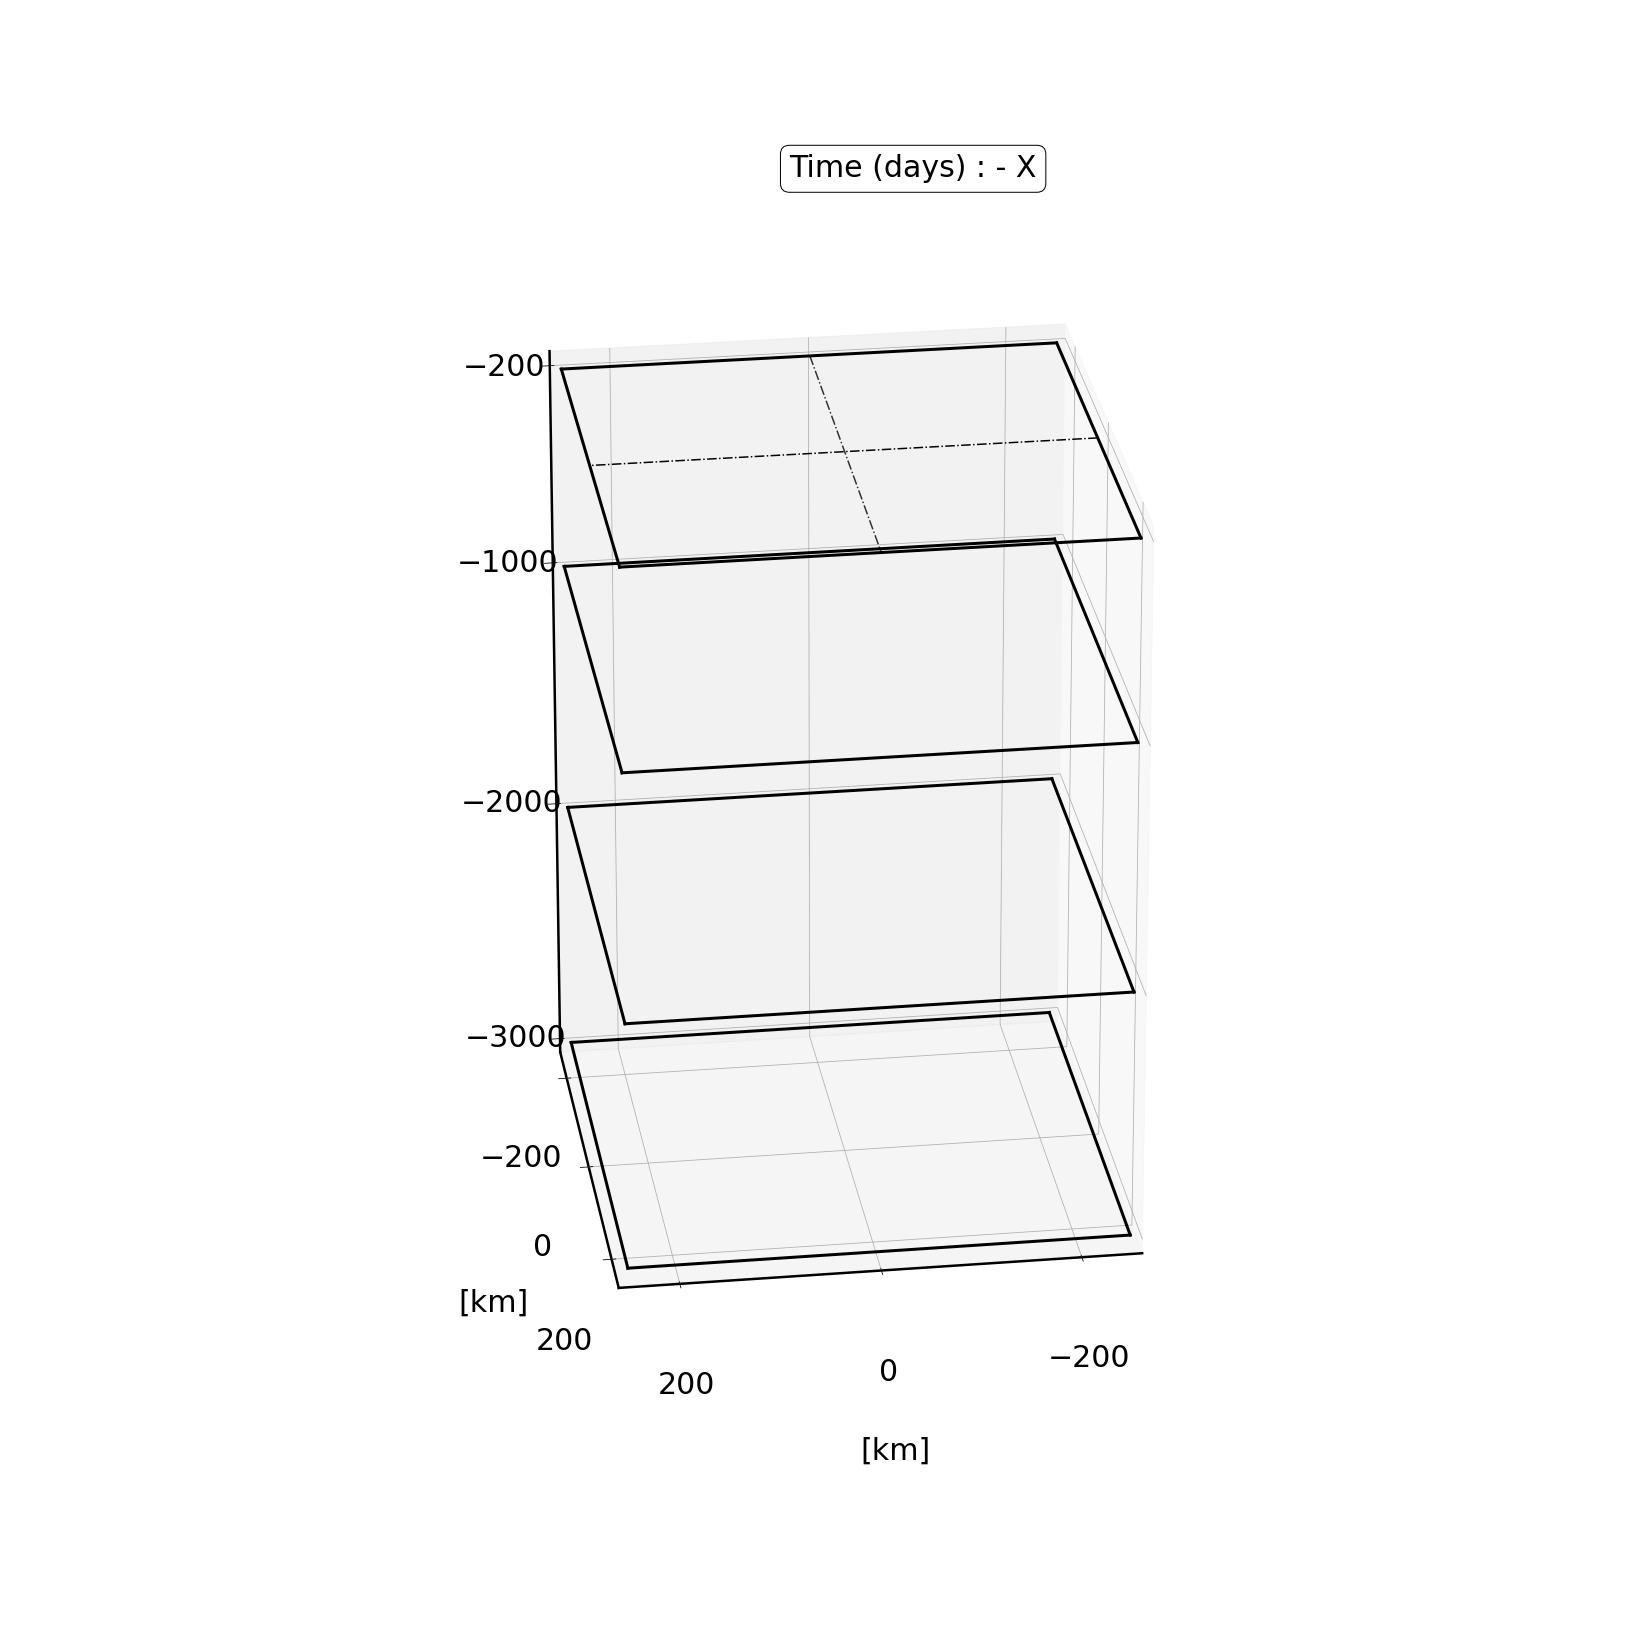

In [81]:
def short_proj():
    return np.dot(Axes3D.get_proj(ax), scale)

fig, ax = plt.subplots(1,1,figsize=(30,30))
ax = plt.axes(projection='3d')
ax.get_proj=short_proj

dt = 80*4 + 20
#dt = 0
figure_part_3D_rotation(dt)

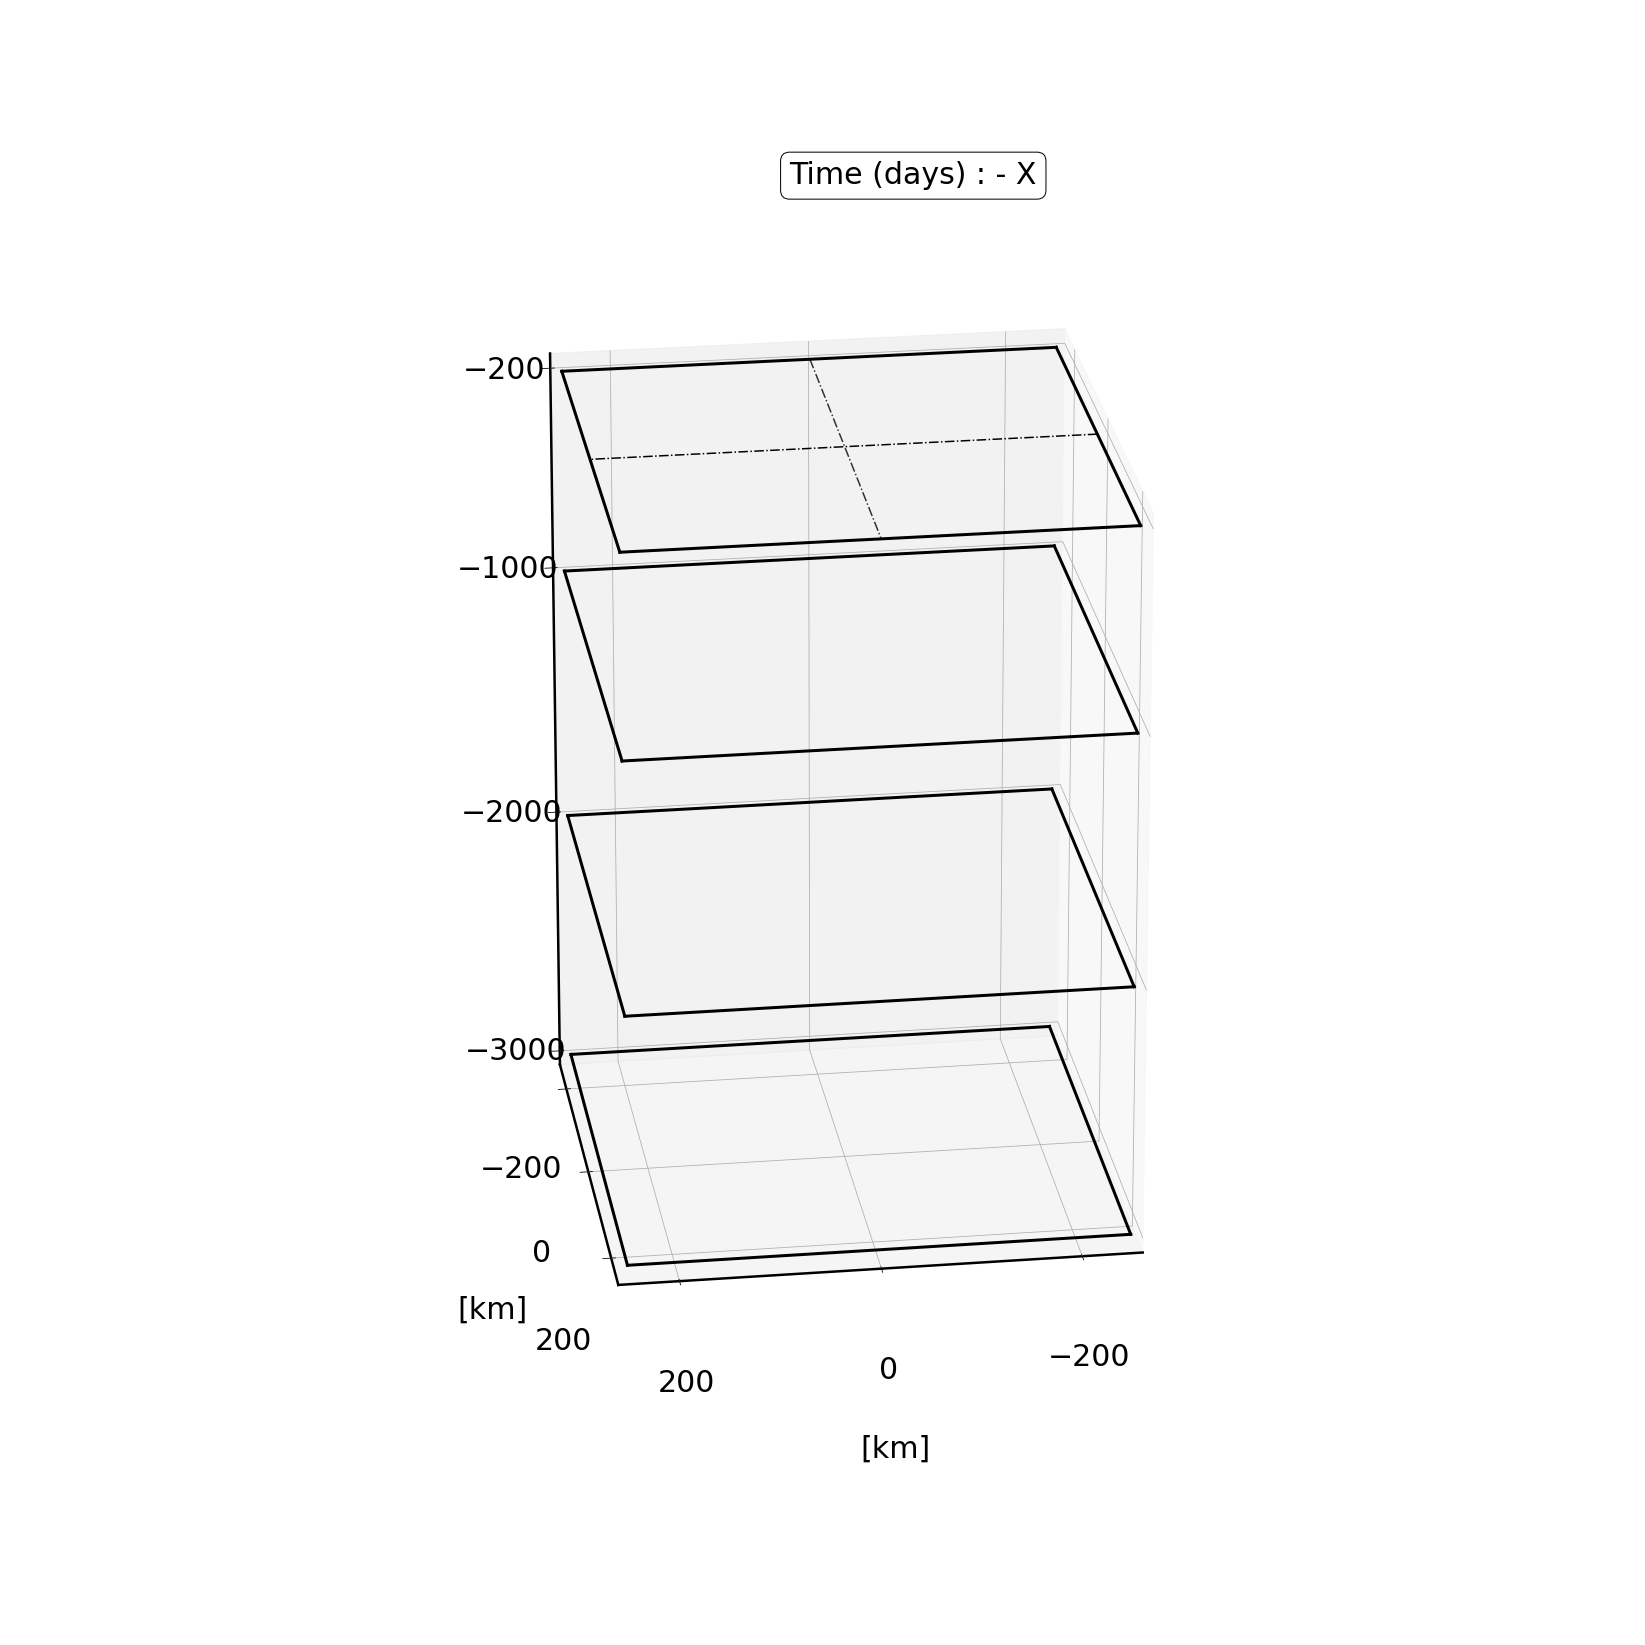

In [82]:
def short_proj():
    return np.dot(Axes3D.get_proj(ax), scale)

fig, ax = plt.subplots(1,1,figsize=(30,30))
ax = plt.axes(projection='3d')
ax.get_proj=short_proj

frames = 80*4 + 20
ani = animation.FuncAnimation(fig, figure_part_3D_rotation, frames=frames, interval=50)
ani.save('test.gif', writer='pillow')